# Last-layer methods
(It's all classical Bayesian stuff)

In [1]:
import jax
import optax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
import flax.linen as nn
from flax.training.train_state import TrainState
from copy import deepcopy

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (7.2, 4.0)

sns.set_palette("colorblind")

# Bayesian linear regression
And the in-between uncertainty

In [3]:
def phi(x):
    return x ** 3

In [4]:
key = jax.random.PRNGKey(3141)
key_data, key_samples = jax.random.split(key)

sigma = 0.3
c = 0.01

In [5]:
n_obs_all = 100
key_x, key_y = jax.random.split(key_data)
x_all = jax.random.uniform(key_x, (n_obs_all,), minval=-7.5, maxval=7.5)
y_all = c * phi(x_all) + jax.random.normal(key_y, shape=(n_obs_all,)) * sigma

mask_vals = jnp.logical_and(jnp.abs(x_all) > 2, jnp.abs(x_all) < 5)
x, y = x_all[mask_vals, None], y_all[mask_vals, None]
n_obs = len(x)

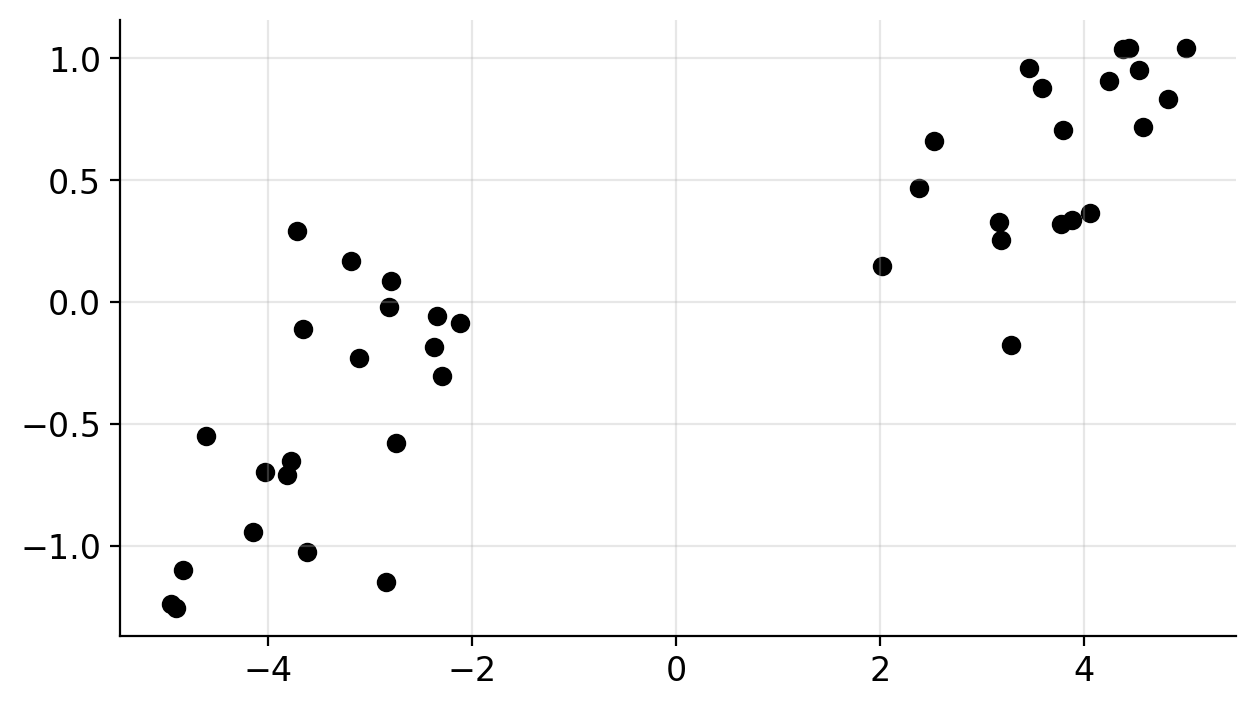

In [6]:
plt.scatter(x, y, c="black")
plt.grid(alpha=0.3)

## Bayesian linear regresion (with known variance)

Suppose
$$
    p(y | x, \beta) = {\cal N}(y | \theta^\intercal\,\phi(x), \beta^{-1})
$$

In [7]:
def phi(x):
    return x ** 3

In [8]:
M = x.shape[1]
IM = jnp.eye(M)
beta = 1 / sigma ** 2 # precision observation

In [9]:
alpha = 1.0
posterior_precision = alpha * IM + beta * phi(x).T @ phi(x)
posterior_mean = beta * jnp.linalg.solve(posterior_precision, phi(x).T @ y)
posterior_mean = posterior_mean.ravel()

In [10]:
n_test_eval = 1000
xeval = jnp.linspace(-7, 7, n_test_eval)
phi_eval = phi(xeval)[:, None]

In [11]:
pred_var = 1 / beta + jnp.einsum("si,ij,sj->s", phi_eval, jnp.linalg.inv(posterior_precision), phi_eval)
pred_std = jnp.sqrt(pred_var)

pred_mean_blr = jnp.einsum("d,td->t", posterior_mean, phi_eval)

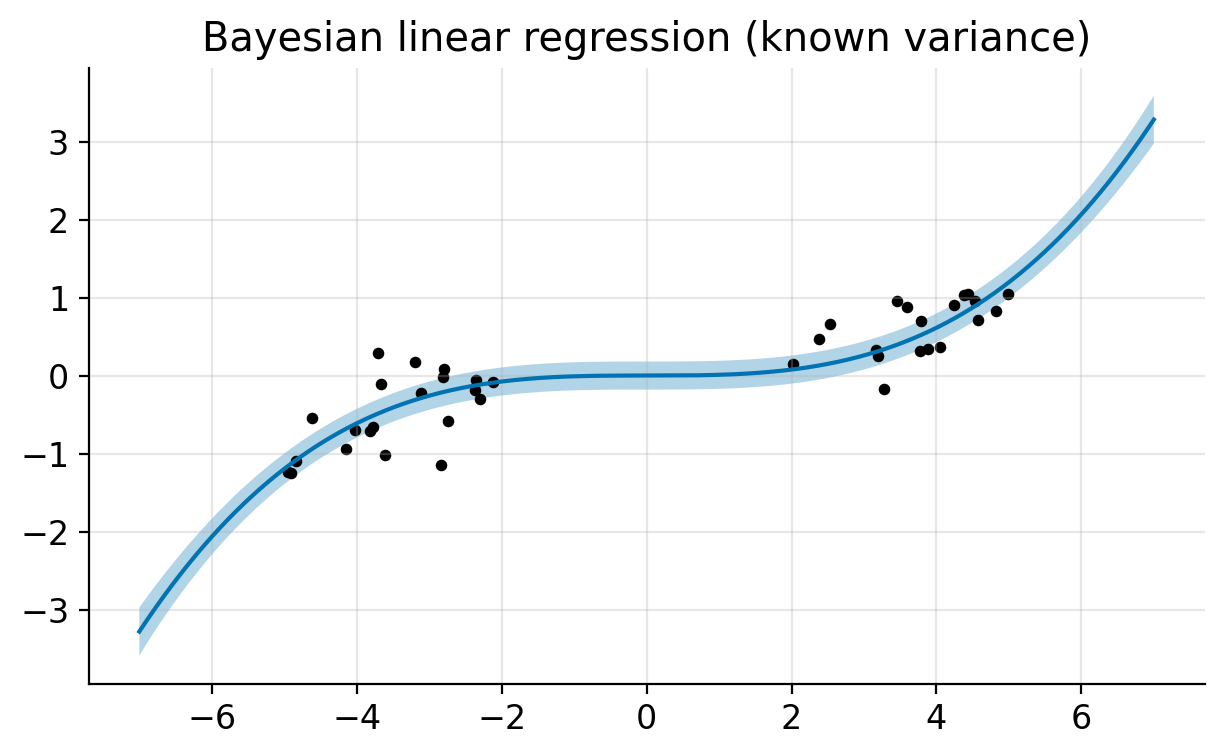

In [12]:
pred_ubound_blr = pred_mean_blr + 2 * pred_var
pred_lbound_blr = pred_mean_blr - 2 * pred_var
plt.fill_between(xeval, pred_lbound_blr, pred_ubound_blr, alpha=0.3)
plt.plot(xeval, pred_mean_blr)
plt.scatter(x, y, c="black", s=10)
plt.title("Bayesian linear regression (known variance)")
plt.grid(alpha=0.3)

## Neural Bayesian last layer

In [13]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.elu(x)
        x = nn.Dense(10)(x)
        x = nn.elu(x)
        x = nn.Dense(1, name="last-layer")(x)
        return x

In [14]:
model = MLP()
key = jax.random.PRNGKey(31415)
params_init = model.init(key, x)

In [15]:
def lossfn(params):
    yhat = model.apply(params, x).squeeze()
    return jnp.power(y.squeeze() - yhat, 2).mean()

In [16]:
def step(state, _):
    loss, grads = jax.value_and_grad(lossfn)(state.params)
    state = state.apply_gradients(grads=grads)
    return  state, loss

n_steps = 3_000
state = TrainState.create(params=params_init, apply_fn=model.apply, tx=optax.adam(1e-3))
state_final, loss = jax.lax.scan(step, state, jnp.arange(n_steps))
params = state_final.params

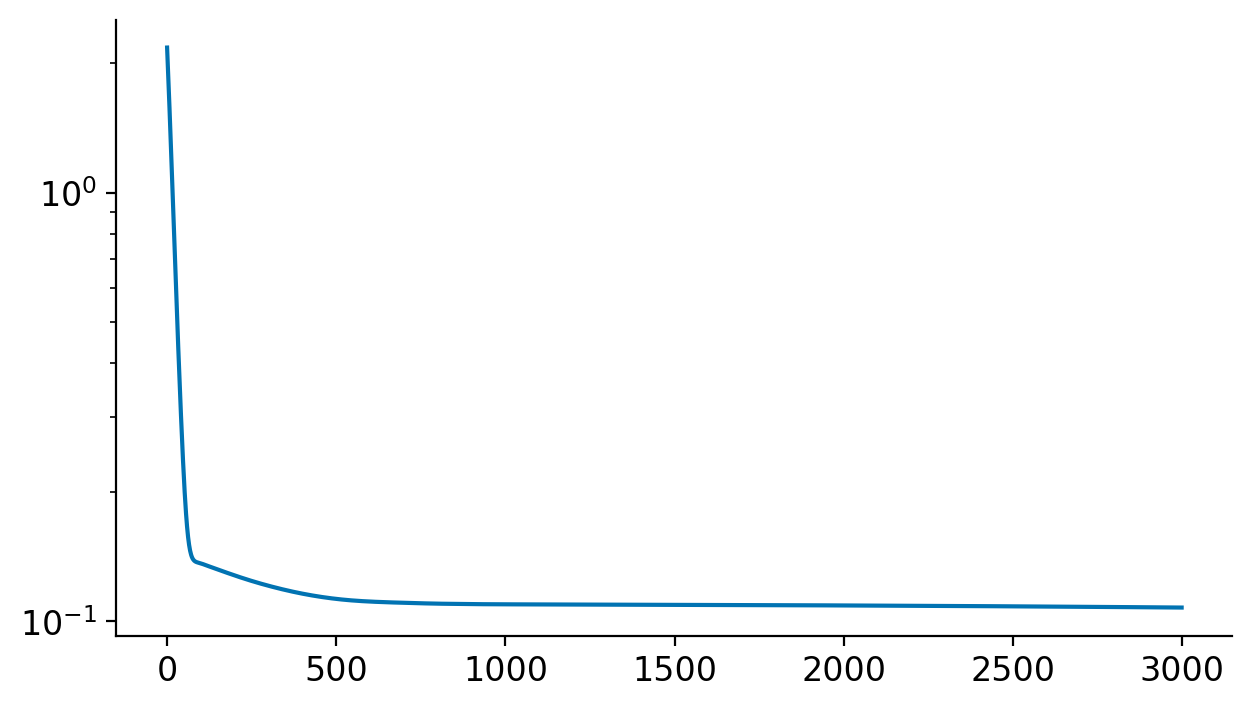

In [17]:
plt.plot(loss)
plt.yscale("log")

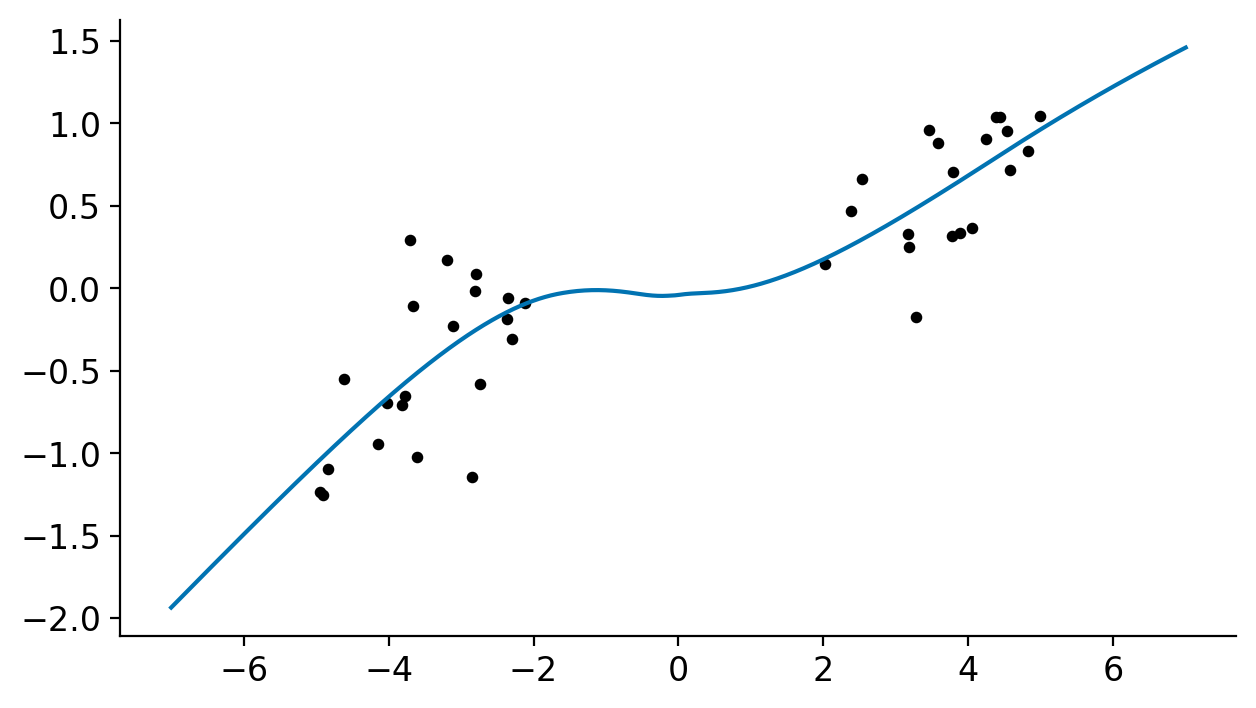

In [18]:
yhat_bnn_eval = model.apply(params, xeval[:, None])
plt.plot(xeval, yhat_bnn_eval)
plt.scatter(x, y, c="black", s=10)

## (plugin) Bayesian Last-layer

In [19]:
class MLPHidden(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.elu(x)
        x = nn.Dense(10)(x)
        x = nn.elu(x)
        return x

In [20]:
mhidden = MLPHidden()

In [21]:
params_hidden = deepcopy(params)
del params_hidden["params"]["last-layer"]

In [22]:
def phi(x):
    return mhidden.apply(params_hidden, x)

In [23]:
M = phi(x).shape[1]
IM = jnp.eye(M)
beta = 1 / sigma ** 2 # precision observation

In [24]:
alpha = 0.05

posterior_precision = alpha * IM + beta * phi(x).T @ phi(x)
posterior_mean = beta * jnp.linalg.solve(posterior_precision, phi(x).T @ y)
posterior_mean = posterior_mean.ravel()

In [25]:
n_test_eval = 1000
phi_eval = phi(xeval[:, None])

In [26]:
pred_var_ll = 1 / beta + jnp.einsum("si,ij,sj->s", phi_eval, jnp.linalg.inv(posterior_precision), phi_eval)
pred_std_ll = jnp.sqrt(pred_var)

pred_mean_ll = jnp.einsum("d,td->t", posterior_mean, phi_eval)

pred_ubound_ll = pred_mean_ll + 2 * pred_var_ll
pred_lbound_ll = pred_mean_ll - 2 * pred_var_ll

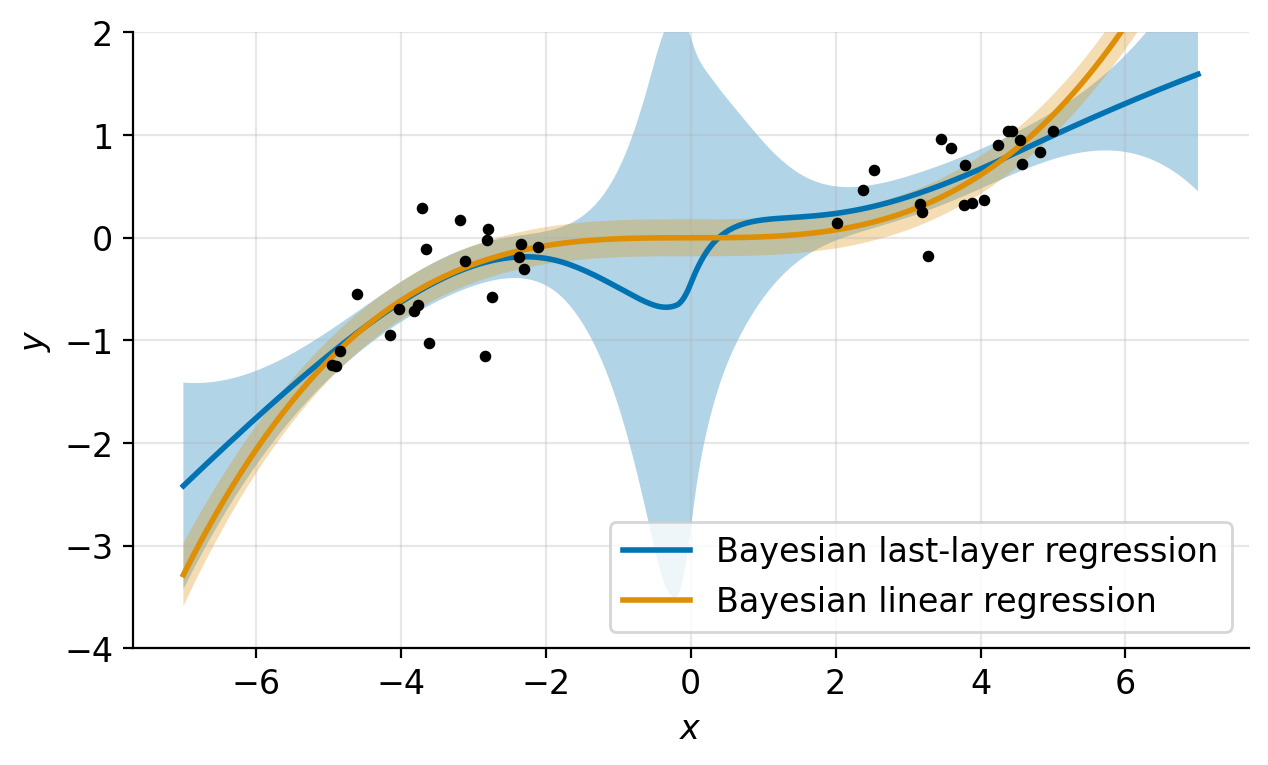

In [27]:
plt.fill_between(xeval, pred_lbound_ll, pred_ubound_ll, alpha=0.3)
plt.plot(xeval, pred_mean_ll, linewidth=2, label="Bayesian last-layer regression")

plt.fill_between(xeval, pred_lbound_blr, pred_ubound_blr, alpha=0.3)
plt.plot(xeval, pred_mean_blr, linewidth=2, label="Bayesian linear regression")

plt.ylim(-4, 2)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.scatter(x, y, c="black", s=10, zorder=3)
plt.grid(alpha=0.3)

## References

* Bishop, Christopher M., and Nasser M. Nasrabadi. Pattern recognition and machine learning. Ch 2. Vol. 4. No. 4. New York: springer, 2006.
* Harrison, James, John Willes, and Jasper Snoek. "Variational bayesian last layers." arXiv preprint arXiv:2404.11599 (2024).